In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import bioframe 
import pandas as pd
import numpy as np 
import os
import json
from io import StringIO

import akita_utils 
import pysam
import h5py
genome_fasta = '/project/fudenber_735/genomes/mm10/mm10.fa'
genome_open = pysam.Fastafile('/project/fudenber_735/genomes/mm10/mm10.fa')

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
import tensorflow as tf
print(tf.__version__)

import pysam
from basenji import dataset, seqnn, dna_io,stream
head_i = 1 #mouse
model_num = 1 #which fold to use

base_dir = '/project/fudenber_735/tensorflow_models/akita/v2/models/'
model_dir = base_dir+"/f"+str(model_num)+"c0/train/"
model_file  = model_dir+'/model'+str(head_i)+'_best.h5'

params_file = model_dir+'/params.json'
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']
seq_length = params_model['seq_length']
params_model['verbose'] = False
seqnn_model = seqnn.SeqNN(params_model)
print('built')
seqnn_model.restore(model_file, head_i=head_i)
print('restored')

hic_diags = params_model['diagonal_offset']
try:
    target_crop = params_model['trunk'][-2]['cropping']
except:
    target_crop = params_model['target_crop']
target_length_cropped = int((seq_length//2048 - target_crop*2 - hic_diags)* ((seq_length//2048 - target_crop*2 - hic_diags) +1)/2) 
target_map_size = seq_length//2048  - target_crop*2 
triu_tup = np.triu_indices(target_map_size,2)
target_map_size, target_length_cropped, triu_tup[0].shape

2.4.1


2022-07-08 13:05:27.669877: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, 1310720, 4)] 0                                            
__________________________________________________________________________________________________
stochastic_reverse_complement ( ((None, 1310720, 4), 0           sequence[0][0]                   
__________________________________________________________________________________________________
stochastic_shift (StochasticShi (None, 1310720, 4)   0           stochastic_reverse_complement[0][
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 1310720, 4)   0           stochastic_shift[0][0]           
____________________________________________________________________________________________

(512, 130305, (130305,))

In [3]:
# with open('backround_seqs.fa','w') as f:
#     for i in range(len(flat_seqs)):
#         f.write('>seq'+str(i)+'_score'+str(int(flat_seqs[i][2]))+'_pixelwise'+str(int(flat_seqs[i][3]*1000))+'\n')
#         f.write(dna_io.hot1_dna(flat_seqs[i][0])+'\n')
       

# Fetching chromosome data to explore background creation

In [4]:
# chromsizes = bioframe.read_chromsizes('/project/fudenber_735/genomes/mm10/mm10.chrom.sizes.reduced')
# bins = bioframe.binnify(chromsizes, 1310720)
# df = bioframe.frac_gc(bins, bioframe.load_fasta('/project/fudenber_735/genomes/mm10/mm10.fa'), return_input=True)
# df

chromsizes = bioframe.read_chromsizes('/project/fudenber_735/tensorflow_models/akita/v2/data/mm10/sequences.bed')#('/project/fudenber_735/genomes/mm10/mm10.chrom.sizes.reduced')#
dframe = pd.DataFrame(chromsizes)
dframe['end'] = dframe['length']+ 1310720
dframe = dframe.reset_index()
dframe.rename(columns = {'index' : 'chrom', 'length':'start'}, inplace = True)
df = bioframe.frac_gc(dframe, bioframe.load_fasta('/project/fudenber_735/genomes/mm10/mm10.fa'), return_input=True)

df

,chrom,start,end,GC
0,chr1,40415232,41725952,0.407777
1,chr1,42708992,44019712,0.424985
2,chr1,42053632,43364352,0.424847
3,chr1,41725952,43036672,0.411407
4,chr1,43036672,44347392,0.417725
...,...,...,...,...
6033,chrX,99241984,100552704,0.424162
6034,chrX,120532992,121843712,0.367963
6035,chrX,139360256,140670976,0.407839
6036,chrX,128737280,130048000,0.370827


array([0.36155923, 0.36484115, 0.36692795, 0.36933852, 0.37136427,
       0.37390693, 0.37647121, 0.3785725 , 0.38098592, 0.38323949,
       0.38545792, 0.38767321, 0.38984203, 0.39225842, 0.39480051,
       0.39695157, 0.39916177, 0.40118296, 0.40297421, 0.40493317,
       0.40676755, 0.4087401 , 0.4107888 , 0.41297816, 0.41495017,
       0.41723744, 0.41918538, 0.42129929, 0.42331508, 0.42498727,
       0.42727323, 0.42928681, 0.43154358, 0.43380009, 0.4356343 ,
       0.43769083, 0.44019318, 0.44228764, 0.44431796, 0.44674923,
       0.44976148, 0.45267083, 0.45646606, 0.46070923, 0.46431695,
       0.46984335, 0.47475862, 0.48120098, 0.48878423, 0.50297072])

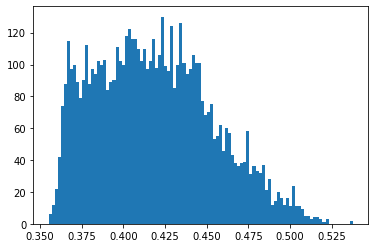

In [5]:
plt.hist( df['GC'].values, 100);
np.percentile(df['GC'].dropna().values, np.linspace(1,99,50))

# Generating a sample for down stream analysis

In [6]:
sample_set = []
error = 0.01
# print(df['GC'].dropna().values[0])

for gc in np.percentile(df['GC'].dropna().values, np.linspace(1,99,50)):
    for i in range(df.shape[0]):
        if gc-error <= df['GC'].values[i] <= gc+error:
            sample_set += [i]
            break

# print(set(sample_set), len(set(sample_set)))

sample_set = list(set(sample_set))

print(sample_set)

sample_set = sample_set[0:10]

print(sample_set)

predictions=[]

for ind in set(sample_set):
    chrom, start, end, gc = df.iloc[ind][['chrom','start','end','GC']]
    genome_open = pysam.Fastafile(genome_fasta)
    seq = genome_open.fetch(chrom, start, end).upper()
    seq_1hot = dna_io.dna_1hot(seq)
    predictions.append(seq_1hot)
    
predictions = np.array(predictions)
predictions = seqnn_model.predict(predictions, batch_size=6)#len(sample_set)
    

[0, 1, 32, 5, 6, 7, 8, 10, 12, 20, 24, 475, 28, 95]
[0, 1, 32, 5, 6, 7, 8, 10, 12, 20]


2022-07-08 13:07:12.402501: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-08 13:07:12.403290: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


In [7]:
test_basepairs= 20 # flanking basepairs to mutate 



# def custom_create_flat_seqs(seqnn_model, genome_fasta, seq_length, dataframe, sample_set, devisor = 5, max_iters = 1, batch_size = 6, shuffle_k = 8, ctcf_thresh = 8, scores_thresh = 5500, scores_pixelwise_thresh = .04 ):
#     '''
#     This function masks basepairs  sorrounding
#     '''
dataframe=df 
sample_set=sample_set 
devisor = 3  # iterations wil be tracked in multiples of this number
max_iters = 1
batch_size = 6 
shuffle_k = 8 
ctcf_thresh = 8 
scores_thresh = 5500 
scores_pixelwise_thresh = .04 

flat_seqs = {}

mot = '>CCAsyAGrkGGCr\n0.0000\t1.0000\t0.0000\t0.0000\n0.0000\t1.0000\t0.0000\t0.0000\n1.0000\t0.0000\t0.0000\t0.0000\n0.0000\t0.5000\t0.5000\t0.0000\n0.0000\t0.5000\t0.0000\t0.5000\n1.0000\t0.0000\t0.0000\t0.0000\n0.0000\t0.0000\t1.0000\t0.0000\n0.5000\t0.0000\t0.5000\t0.0000\n0.0000\t0.0000\t0.5000\t0.5000\n0.0000\t0.0000\t1.0000\t0.0000\n0.0000\t0.0000\t1.0000\t0.0000\n0.0000\t1.0000\t0.0000\t0.0000\n0.5000\t0.0000\t0.5000\t0.0000'
motif = pd.read_csv(StringIO(mot),sep='\t',header=0, names=['A','C','G','T']).values
motif_window = int(np.ceil(len(motif)/2))
# mot_shuf = np.array([12,0,1,11,10,3,2,8,9,4,5,7,6]) 
mot_shuf = np.array([12]*test_basepairs)


for ind in sample_set: #range(10,num_seqs):
    print(ind)
    chrom, start, end, gc = dataframe.iloc[ind][['chrom','start','end','GC']]
    genome_open = pysam.Fastafile(genome_fasta)
    seq = genome_open.fetch(chrom, start, end).upper()
    seq_1hot = dna_io.dna_1hot(seq)

    num_iters = 0
    while num_iters < max_iters:
        print('ind',ind, ', iter ',num_iters,', for', chrom, start, end)
        print(len(flat_seqs))

        seq_1hot_batch = []
        for i in range(batch_size):
            seq_1hot_mut = seq_1hot #akita_utils.permute_seq_k(seq_1hot,k= shuffle_k)
            s = akita_utils.scan_motif(seq_1hot_mut, motif  )
            for i in np.where(s > ctcf_thresh)[0]:
                i = i - motif_window
                #seq_1hot_mut[i-motif_window:i+motif_window] = permute_seq_k(seq_1hot_mut[i-motif_window:i+motif_window], k=2)
                seq_1hot_mut[i-test_basepairs:i] = akita_utils.permute_seq_k(seq_1hot_mut[i-test_basepairs:i],k= 2)
                seq_1hot_mut[i+(2*motif_window):i+(2*motif_window)+test_basepairs] = akita_utils.permute_seq_k(seq_1hot_mut[i+(2*motif_window):i+(2*motif_window)+test_basepairs],k=2)
                
            seq_1hot_batch.append(seq_1hot_mut)
        seq_1hot_batch = np.array(seq_1hot_batch)

        pred = seqnn_model.predict(seq_1hot_batch, batch_size=batch_size)
        scores = np.sum( pred**2, axis=-1).sum(axis=-1)
        scores_pixelwise = np.max(pred**2, axis=-1).max(axis=-1)



        if np.any( (np.min(scores) < scores_thresh) * (np.min(scores_pixelwise) < scores_pixelwise_thresh)):
            best_ind = np.argmin(scores_pixelwise)
            best_seq = seq_1hot_batch[best_ind]
            best_pred = pred[best_ind]
            best_score, best_score_pixelwise = scores[best_ind] , scores_pixelwise[best_ind]
            num_iters = max_iters
            print('success: best seq, thresh', np.min(scores),' pixelwise',np.min(scores_pixelwise))

        else: 
            best_ind = np.argmin(scores_pixelwise)
            best_seq = seq_1hot_batch[best_ind]
            best_pred = pred[best_ind]
            best_score, best_score_pixelwise = scores[best_ind] , scores_pixelwise[best_ind]
            print('trying: best seq, thresh', np.min(scores),' pixelwise',np.min(scores_pixelwise))


        if num_iters%devisor ==0:
            flat_seqs[sample_set.index(ind),num_iters] =  [best_seq, best_pred, best_score, best_score_pixelwise,gc] 

        num_iters +=1
        if num_iters >= max_iters:
            print('max iters exceeded')
            flat_seqs[sample_set.index(ind),'final'] = [best_seq, best_pred, best_score, best_score_pixelwise,gc] 
            #raise ValueError('cannot generate flat sequence for', chrom, start, end)

# return flat_seqs


0
ind 0 , iter  0 , for chr1 40415232 41725952
0
trying: best seq, thresh 31300.0  pixelwise 0.3093
max iters exceeded
1
ind 1 , iter  0 , for chr1 42708992 44019712
2
trying: best seq, thresh 33150.0  pixelwise 1.471
max iters exceeded
32
ind 32 , iter  0 , for chr1 135311360 136622080
4


/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


trying: best seq, thresh inf  pixelwise 1.485
max iters exceeded
5
ind 5 , iter  0 , for chr1 37793792 39104512
6


/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


trying: best seq, thresh inf  pixelwise 2.629
max iters exceeded
6
ind 6 , iter  0 , for chr1 39432192 40742912
8
trying: best seq, thresh 41760.0  pixelwise 1.094
max iters exceeded
7
ind 7 , iter  0 , for chr1 38449152 39759872
10


/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


trying: best seq, thresh inf  pixelwise 1.1455
max iters exceeded
8
ind 8 , iter  0 , for chr1 38776832 40087552
12


/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


trying: best seq, thresh inf  pixelwise 1.602
max iters exceeded
10
ind 10 , iter  0 , for chr1 41070592 42381312
14
trying: best seq, thresh 5390.0  pixelwise 0.05063
max iters exceeded
12
ind 12 , iter  0 , for chr1 36483072 37793792
16
trying: best seq, thresh 45950.0  pixelwise 0.8726
max iters exceeded
20
ind 20 , iter  0 , for chr1 36155392 37466112
18
trying: best seq, thresh 60000.0  pixelwise 0.6904
max iters exceeded


In [1]:
fig = plt.figure(figsize=(6* 2 , 6 *  len(sample_set) ), constrained_layout=True)     
spec = fig.add_gridspec(ncols=2, nrows=len(sample_set), hspace=0.1, wspace=0.1)#
           
target_ind = 0
vmin=-2; vmax=2

for i in range(len(sample_set)):
    
    flat_pred = flat_seqs[i][1]
    gc        = flat_seqs[i][-1]
    back_pred = predictions[i]

    mat = akita_utils.from_upper_triu(back_pred[:,target_ind], target_map_size,hic_diags)
    ax1 = fig.add_subplot(spec[i,0])
    im = ax1.matshow(mat, cmap='RdBu_r', vmin=vmin, vmax=vmax)# 
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])
    plt.title(f'Sequence_{i} GC content_{gc} before')       
           
    mat = akita_utils.from_upper_triu(flat_pred[:,target_ind], target_map_size,hic_diags)
    ax2 = fig.add_subplot(spec[i,1])
    im = ax2.matshow(mat, cmap='RdBu_r', vmin=vmin, vmax=vmax)# 
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2])       
    plt.title(f'Sequence_{i} GC content_{gc} after')       
        
plt.show()

NameError: name 'plt' is not defined